In [1]:
import sys 
# locate to the working folder
# sys.path.append("D:\\GitHub\\Clone\\planning\\ruixuan")
from ruixuan.turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time
import pickle
import math
from collections import deque
import random

D:\Anaconda\lib\site-packages\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  "Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows."


In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\prediction-dataset"
# get config
cfg = load_config_data("C:\\Users\\zheng\\Desktop\\UMich\\Independent Study\\Codes\\python codes\\visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)
# Obatin the information from semantic map

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [300, 300], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-

In [304]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle',\
                           'Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction_boundary):

        self.scene = scene
        self.target_label = target_label
#         self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
#         junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary)

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
        
    def get_agent_traj(self, scene, target_label, lane_region, lane_list):
        veh_traj, ped_traj, cyclist_traj=[], [], [] 
#         print(self.label_dict, self.label_dict[target_label])
        for idx, agent_label in enumerate(self.agent_list):
#             print("xxx", idx, agent_label)
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx == self.label_dict['Car']-3 and agent_loc.shape[0] > 100  \
                and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 10 and traj_check(agent_loc, lane_region, lane_list):
                    veh_traj.append(agent_loc)
#                     plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '\
#                              +self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and agent_loc.shape[0] > 100:
                    ped_traj.append(agent_loc)
            
            
                elif idx== self.label_dict['Cyclist']-3 and agent_loc.shape[0] > 100:
                    cyclist_traj.append(agent_loc)
                    
        veh_traj, ped_traj, cyclist_traj = np.array(veh_traj), np.array(ped_traj), np.array(cyclist_traj)
        return veh_traj, ped_traj,cyclist_traj
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction, lane_list):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))

        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 100  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and  agent_loc.shape[0] > 100:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()

In [315]:
def get_trajectory(intersection_id, scene, junction_boundary, lane_region, lane_list_dict):
    
    Test.agent_trajectory(scene, 'Pedestrian', junction_boundary[intersection_id])
    veh_traj, ped_traj,cyclist_traj = Test.get_agent_traj(scene, 'Pedestrian', lane_region, lane_list_dict[intersection_id])
    return veh_traj, ped_traj,cyclist_traj

In [306]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

# Find the entire turning scene at lane_merge 

In [7]:
lane_merge_full = []

for idx, scene in tqdm(enumerate(Test.dataset.scenes[:])):
    
    begin_location = Test.frames[scene[0][0]]['ego_translation'][:2]
    end_location = Test.frames[scene[0][1]-1]['ego_translation'][:2]
    
    if end_location[1] > 1430 and begin_location[1] < 1415:
        
        lane_merge_full.append(idx)

134622it [04:41, 477.55it/s]


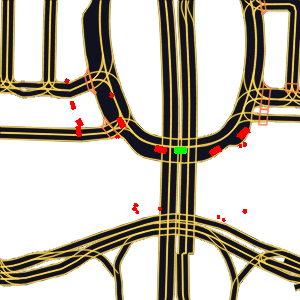

In [249]:
Test.scene_visualize(950, ego_dataset, cfg)

In [279]:
def get_grid(intersection_id,grid_boundary):
    x = grid_boundary[intersection_id]['X']
    y = grid_boundary[intersection_id]['Y']
    x_ = np.linspace(x[0], x[1],150)
    y_ = np.linspace(y[0], y[1],150)
    x_mesh, y_mesh = np.meshgrid(x_, y_)
    return x_mesh, y_mesh

def locate_in_mesh(x_mesh, y_mesh, point):
    x, y = point[0], point[1]
    result=[]
#     print(x, y, x_mesh[0], x_mesh[-1], y_mesh[0], y_mesh[-1])
    if x>x_mesh[-1] or x<x_mesh[0] or y>y_mesh[-1] or y<y_mesh[0]:
        return None
    result = [math.floor(x-x_mesh[0]), math.floor(y-y_mesh[0])]
    return result

def plot_scene_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None, cyc=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    plt.figure(figsize=(18,18))
    plt.xlim(grid_boundary['lane_merge']['X'][0],grid_boundary['lane_merge']['X'][1])
    plt.ylim(grid_boundary['lane_merge']['Y'][0],grid_boundary['lane_merge']['Y'][1])
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
    plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
    plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)

    if veh is not None:
        for traj in veh: plt.plot(traj[:,0],traj[:,1], c='b',linewidth=0.5)
    if ped is not None:
        for traj in ped: plt.scatter(traj[:,0],traj[:,1], c='orange',linewidth=0.5)
    if cyc is not None:
        for traj in cyc: plt.plot(traj[:,0],traj[:,1], c='cyan',linewidth=0.5)
    plt.axis('off')
    plt.show()

In [316]:
veh_traj, ped_traj,cyc_traj = get_trajectory('lane_merge', 2867, junction_boundary, lane_region, lane_list_dict) # 2209
print(veh_traj.shape, ped_traj.shape, cyc_traj.shape)

(2, 249, 2) (1, 175, 2) (0,)


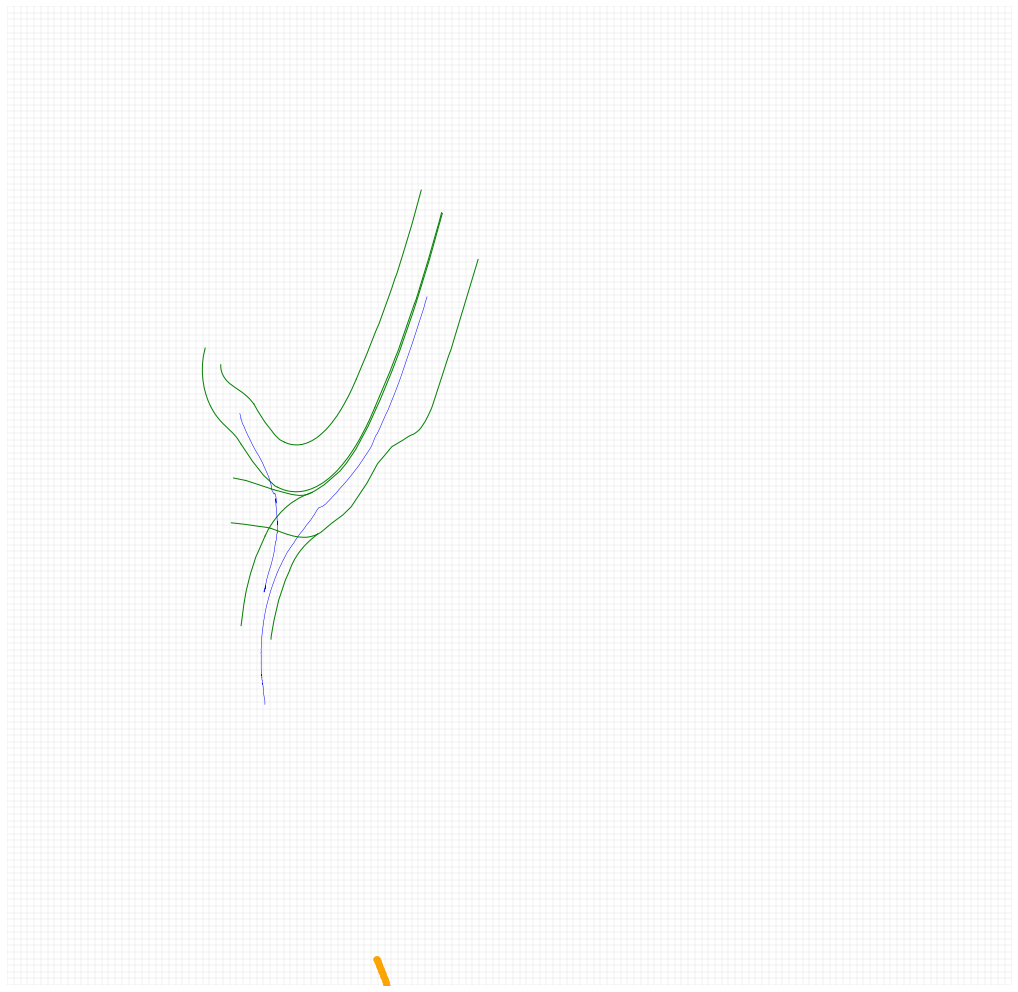

In [317]:
plot_scene_on_grid('lane_merge', lane_list=lane_list, \
                           grid_boundary=grid_boundary, veh=veh_traj, ped=ped_traj, cyc=cyc_traj)

In [320]:
def extract_trajectory_in_scene(scene, Test, zarr_dataset, intersection_id, grid_boundary, lane_region, lane_list_dict):
    """
    get downsampled trajectory in a scene
    return: ego, veh, ped, cyc trajectories
    """
    frame_interval = zarr_dataset.scenes[scene]['frame_index_interval']
    length = frame_interval[1] - frame_interval[0]
#     print(length)
    
    if length<245:
        return [], [], []
    
    veh_traj, ped_traj, cyc_traj = get_trajectory('lane_merge', scene, junction_boundary, lane_region, lane_list_dict)

#     sampling_id=range(0, 240,5)
    
    all_veh_traj=[]
    all_ped_traj=[]
    all_cyc_traj=[]
    
    if veh_traj.size > 0:
        for car in veh_traj:
            temp_traj = []
            for idx, frame in enumerate(range(0, min(240,car.shape[0]),5)):
                temp_traj.append(car[::-1][frame])
                
                if len(temp_traj)==20 and traj_check(temp_traj[::-1], lane_region, lane_list_dict[intersection_id]) and temp_traj[::-1][-1][0]>-939:
                    all_veh_traj.append(temp_traj[::-1])
                    temp_traj=[] 
                
    if ped_traj.size > 0:
        
        for ped in ped_traj:
            temp_traj = []
            for idx, frame in enumerate(range(0, min(240,ped.shape[0]),5)):
                temp_traj.append(ped[::-1][frame])
                
                if len(temp_traj)==20:
                    all_ped_traj.append(temp_traj[::-1])
                    temp_traj=[]     

    if cyc_traj.size > 0:
        
        for cyc in cyc_traj:
            temp_traj = []
            for idx, frame in enumerate(range(0, min(240,cyc.shape[0]),5)):
                temp_traj.append(cyc[::-1][frame])
                
                if len(temp_traj)==20:
                    all_cyc_traj.append(temp_traj[::-1])
                    temp_traj=[]
                    
    return np.array(all_veh_traj), np.array(all_ped_traj), np.array(all_cyc_traj)

In [321]:
# run an example
all_veh_traj, all_ped_traj, all_cyc_traj = extract_trajectory_in_scene(2867, Test, zarr_dataset, 'lane_merge', grid_boundary, lane_region, lane_list_dict) # 2148, 5532
print(all_veh_traj.shape)
print(all_ped_traj.shape)
print(all_cyc_traj.shape)

(4, 20, 2)
(1, 20, 2)
(0,)


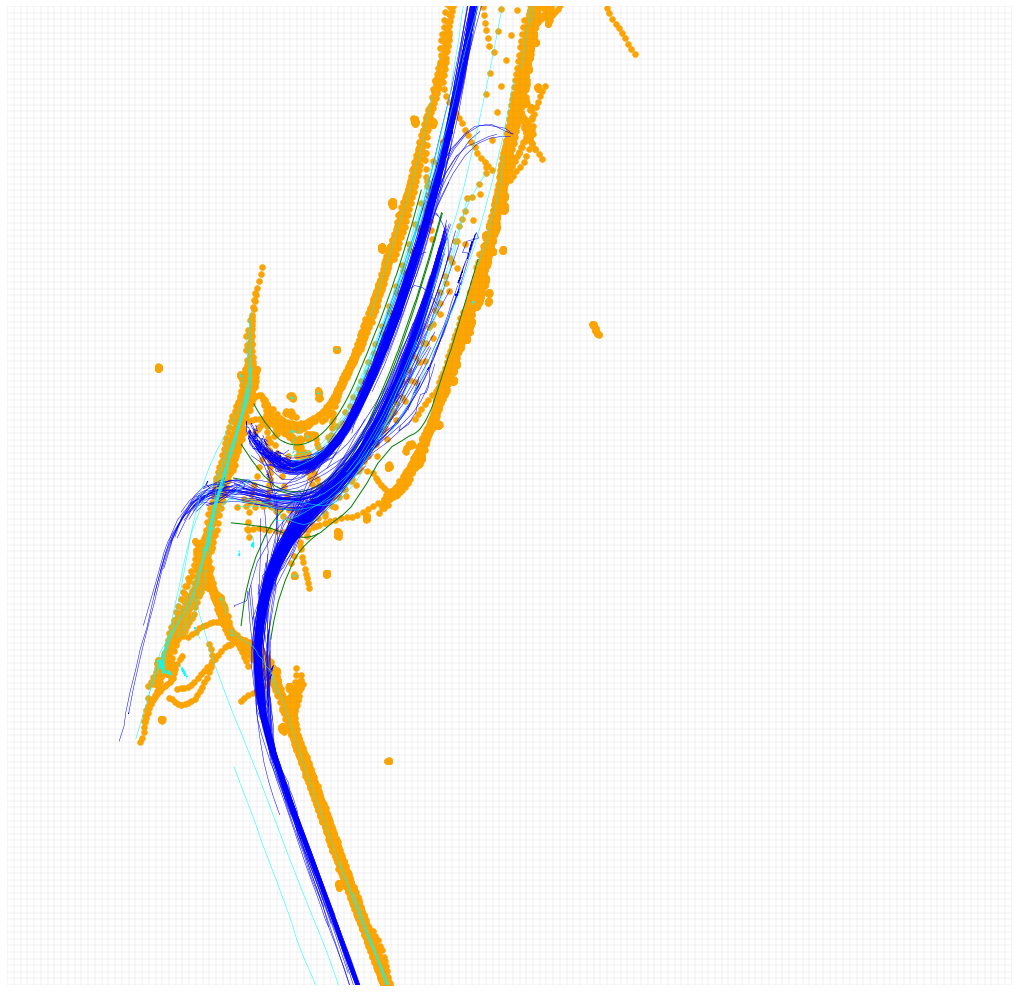

In [291]:
plot_scene_on_grid('lane_merge', lane_list=lane_list, \
                           grid_boundary=grid_boundary, veh=final_veh, ped=final_ped, cyc=final_cyc)

In [90]:
lane_region = {}
for lane in lane_list_dict['lane_merge']:
    boundary = Test.map_api.get_lane_coords(lane)
    left_boundary = boundary['xyz_left']
    right_boundary = boundary['xyz_right']
    left_boundary_point = [(line[0],line[1])for line in left_boundary]
    right_boundary_point = [(line[0],line[1])for line in reversed(right_boundary)]
    lane_region[lane] = Polygon(left_boundary_point+right_boundary_point)

In [62]:
def traj_check(traj, lane_region, lane_list):
    end_point = Point(traj[-1][0], traj[-1][1])
    for lane in lane_list:    
        if lane_region[lane].contains(end_point):
            return True

In [43]:
lane_list_dict = {}
junction_boundary_dict = {}
# extend lane sequences
lane_list_dict['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU','Yu8q']
#lane_list['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU','/4bV','9JSg','Yu8q','9rUz','bdWF','U1+8','7/jP','dfr0','9E7T','c/jP','zoG2','020R','6dWF']
lane_list_dict['8KfB'] = ['/24B','6p63','FV1O','MV/U','SxVb','TG2b','TZZv','ZnUV','bH1o','dddQ','nXc0','zHjP','SD8o','vC8o']
junction_boundary_dict['lane_merge'] = [(-940,1380),(-940,1480),(-880,1380),(-880,1480)]
junction_boundary_dict['8KfB'] = [(500,-2420),(500,-2360),(560,-2360),(560,-2420)]
# junction_boundary['8KfB'] = [(450,-2400),(500,-2360),(560,-2360),(560,-2420)]

In [228]:
lane_merge_valid_full = []

for scene in tqdm(lane_merge_full):
    
    result = Test.agent_trajectory(scene, 'Pedestrian', junction_boundary['lane_merge'])
    
    if len(result) >0:
        lane_merge_valid_full.append(scene)
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 907/907 [01:28<00:00, 10.25it/s]


In [244]:
def get_allscenes_intersection(junction_scenes=lane_merge_valid_full):
    final_veh, final_ped, final_cyc=None, None, None
    all_scene_dict={}
    for _, scene in enumerate(junction_scenes):
        scene_dict={'veh':[], 'ped':[], 'cyc':[]}
        print("i-th, scene", _, scene)
        all_veh_traj, all_ped_traj, all_cyc_traj = extract_trajectory_in_scene(scene, Test, zarr_dataset, 'lane_merge', grid_boundary, lane_region, lane_list['lane_merge']) # 3134

        if len(all_veh_traj)>0:
            scene_dict['veh']=all_veh_traj
            if final_veh is None:
                final_veh = all_veh_traj
            else:
                final_veh = np.vstack((final_veh, all_veh_traj))

        if len(all_ped_traj)>0:
            scene_dict['ped']=all_ped_traj
            if final_ped is None:
                final_ped = all_ped_traj
            else:
                final_ped = np.vstack((final_ped, all_ped_traj))

        if len(all_cyc_traj)>0:
            scene_dict['cyc']=all_cyc_traj
            if final_cyc is None:
                final_cyc = all_cyc_traj
            else:
                final_cyc = np.vstack((final_cyc, all_cyc_traj))
        all_scene_dict[_]=scene_dict
    #     if _>3:
    #         break
    np.save("lane_merge_alltraj_veh", final_veh)
    np.save("lane_merge_alltraj_ped", final_ped)
    np.save("lane_merge_alltraj_cyc", final_cyc)
    print('saved')
    
    return final_veh, final_ped, final_cyc, all_scene_dict

In [289]:
final_veh, final_ped, final_cyc, all_scene_dict = get_allscenes_intersection()
print(final_veh.shape, final_ped.shape, final_cyc.shape)

i-th, scene 0 370
i-th, scene 1 539
i-th, scene 2 581
i-th, scene 3 782
i-th, scene 4 839
i-th, scene 5 950
i-th, scene 6 1005


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


i-th, scene 7 1064
i-th, scene 8 1266
i-th, scene 9 1301
i-th, scene 10 1303
i-th, scene 11 1324
i-th, scene 12 1449
i-th, scene 13 1605
i-th, scene 14 1634
i-th, scene 15 1734
i-th, scene 16 1783
i-th, scene 17 1833
i-th, scene 18 1994
i-th, scene 19 2069
i-th, scene 20 2359
i-th, scene 21 2695
i-th, scene 22 2756
i-th, scene 23 2802
i-th, scene 24 2918
i-th, scene 25 3038
i-th, scene 26 3097
i-th, scene 27 3282
i-th, scene 28 3338
i-th, scene 29 3586
i-th, scene 30 3743
i-th, scene 31 3797
i-th, scene 32 4023
i-th, scene 33 4958
i-th, scene 34 5047
i-th, scene 35 5223
i-th, scene 36 5333
i-th, scene 37 5392
i-th, scene 38 5447
i-th, scene 39 5502
i-th, scene 40 5556
i-th, scene 41 5603
i-th, scene 42 5650
i-th, scene 43 5707
i-th, scene 44 5930
i-th, scene 45 6039
i-th, scene 46 6179
i-th, scene 47 6238
i-th, scene 48 6667
i-th, scene 49 6760
i-th, scene 50 6865
i-th, scene 51 6926
i-th, scene 52 7120
i-th, scene 53 7175
i-th, scene 54 7381
i-th, scene 55 7509
i-th, scene 56 7576
i-t

In [241]:
final_ped

# Generate the test and training dataset

In [292]:
partition_factor = 0.2

def dataset_generation(alltraj, partition_factor = partition_factor):
    
    num = alltraj.shape[0]
    num_test = round(num*partition_factor)
    num_train = num - num_test
    
    shuffled_alltraj = np.random.permutation(alltraj)
    
    test = shuffled_alltraj[:num_test,:,:]
    train_raw = shuffled_alltraj[num_test:,:,:]
    
    train = np.zeros([num_train*10,11,2])
    for idx, traj in enumerate(train_raw):   
        for i in range(10):
            train[idx*10+i,:,:] = traj[i:i+11,:]
        
        
    return test, train       

In [293]:
test_cyc, train_cyc = dataset_generation(final_cyc, partition_factor = partition_factor)
test_ped, train_ped = dataset_generation(final_ped, partition_factor = partition_factor)
test_veh, train_veh = dataset_generation(final_veh, partition_factor = partition_factor)

In [294]:
def coordinate_augmentation(test, train):
    
    test_output = np.zeros([test.shape[0],20,4])
    test_output[:,:,:2] = test
    
    for idx, traj in enumerate(test):
        test_output[idx,:,2:] = traj-traj[0,:]
     
    
    train_output = np.zeros([train.shape[0],11,4])
    train_output[:,:,:2] = train
    
    for idx, traj in enumerate(train):
        train_output[idx,:,2:] = traj-traj[0,:]
        
    train_output = np.random.permutation(train_output)
    
    return test_output, train_output
    

In [295]:
cyc_test_output, cyc_train_output = coordinate_augmentation(test_cyc, train_cyc)
ped_test_output, ped_train_output = coordinate_augmentation(test_ped, train_ped)
veh_test_output, veh_train_output = coordinate_augmentation(test_veh, train_veh)

In [296]:
np.save("cyc_test_set_lane_merge", cyc_test_output)
np.save("cyc_train_set_lane_merge", cyc_train_output)
np.save("ped_test_set_lane_merge", ped_test_output)
np.save("ped_train_set_lane_merge", ped_train_output)
np.save("veh_test_set_lane_merge", veh_test_output)
np.save("veh_train_set_lane_merge", veh_train_output)

# GM+Gibbs

In [297]:
from sklearn.mixture import BayesianGaussianMixture
from tabulate import tabulate

def crop(array, max_n_agent=10, is_cyc=False):
    
    if len(array)>=max_n_agent:
        return np.array(array[:max_n_agent])
    if len(array)<max_n_agent:
        complement = np.zeros(shape=(max_n_agent-len(array), 20, 2))
        if len(array)==0:return complement
        if is_cyc:
            replica = math.ceil(max_n_agent/len(array))
            array=list(array)*replica
            return np.array(array[:max_n_agent])
        array = np.vstack((array, complement))
        return array
    else:
        return array

def _get_models(all_scene_dict):
    """
    1. convert trajectories in a scene into a sample [20, 20, 2]-> [20, 40]
    2. BGM
    3. distribution genetation
    """
    training_veh, training_ped, training_cyc = [], [], []
    for scene, scene_dict in all_scene_dict.items():
        veh, ped, cyc = np.array(scene_dict['veh']), np.array(scene_dict['ped']), np.array(scene_dict['cyc'])
        veh = crop(veh)
        ped = crop(ped)
        cyc = crop(cyc,is_cyc=True)
        

        training_veh.append(veh.flatten())
        training_ped.append(ped.flatten())
        training_cyc.append(cyc.flatten())
    print("...", np.array(training_veh).shape)
    training_veh = np.array(training_veh)
    training_ped = np.array(training_ped)
    training_cyc = np.array(training_cyc)
    
    print("training veh")
    bgm_veh = BayesianGaussianMixture(n_components=3, random_state=10, reg_covar=1e-5, n_init=3).fit(training_veh)
    print("training ped")
    bgm_ped = BayesianGaussianMixture(n_components=3, random_state=20, reg_covar=1e-5, n_init=3).fit(training_ped)
    print("training cyc")
    bgm_cyc = BayesianGaussianMixture(n_components=3, random_state=30, reg_covar=1e10, max_iter=200,n_init=3).fit(training_cyc)
    
    return bgm_veh, bgm_ped, bgm_cyc
    
    
def _get_scene_encodings(all_scene_dict, veh_model, ped_model, cyc_model):
    
    
    scene_encoding=[]
    veh_pool, ped_pool, cyc_pool={}, {}, {}
    for scene, scene_dict in all_scene_dict.items():
        veh, ped, cyc = np.array(scene_dict['veh']), np.array(scene_dict['ped']), np.array(scene_dict['cyc'])
        
        veh_p = crop(veh)
        ped_p = crop(ped)
        cyc_p = crop(cyc,is_cyc=True)
        x = veh_model.predict([veh_p.flatten()])
        y = ped_model.predict([ped_p.flatten()])
        z = cyc_model.predict([cyc_p.flatten()])
        scene_encoding.append([x[0],y[0],z[0]])
        
        if x[0] in veh_pool and len(veh)>0:
            veh_pool[x[0]] = np.vstack((veh_pool[x[0]], veh))
        elif len(veh)>0:
            veh_pool[x[0]]= veh
            
        
        if y[0] in ped_pool and len(ped)>0:
            ped_pool[y[0]] = np.vstack((ped_pool[y[0]], ped))
        elif len(ped)>0:
            ped_pool[y[0]]= ped
            
        if z[0] in cyc_pool and len(cyc)>0:
#             print(cyc_pool[z[0]], "cyc", cyc)
            cyc_pool[z[0]] = np.vstack((cyc_pool[z[0]], cyc))
        elif len(cyc)>0:
            cyc_pool[z[0]]= cyc
        
    return np.array(scene_encoding), veh_pool, ped_pool, cyc_pool

def _get_distribution(encodings):
    """
    compute #p(Y/X), P(Z/X), P(X/Y,Z)
    """
     
    Pxy, Pxz=[],[]
    headers = ["X=0", "X=1", "X=2"]
    
    n=len(encodings)
    for x  in range(3):
        idx = np.where(encodings[:,0]==x)
        arr = encodings[idx]
#         print('-',len(arr))
        pxy=[]
        for y in range(3):
            p_arr_idx = np.where(arr[:,1]==y)
            p_arr = arr[p_arr_idx]
#             print('--', len(p_arr))
            p = len(p_arr)/n
            pxy.append(p)
        Pxy.append(pxy)

        pxz=[]
        for z in range(3):
            c_arr_idx = np.where(arr[:,2]==z)
            c_arr = arr[c_arr_idx]
            p = len(c_arr)/n
            pxz.append(p)
        Pxz.append(pxz)
    print(np.array(Pxy), np.sum(Pxy))
    
    Pyzx=[]
    
    for pi in range(3):
        pp=[]
        arr_idx= np.where(encodings[:,1]==pi)
        pi_arr=encodings[arr_idx]
        for zi in range(3):
            pz=[]
            if len(pi_arr)==0:
                pz.append(0)
            else:    
                zarr_idx = np.where(pi_arr[:,2]==zi)
                if len(arr_idx)==0:
                    pz.append(0)
                else:
                    zi_arr = pi_arr[zarr_idx]
                    for xi in range(3):
                        xarr_idx= np.where(zi_arr[:,0]==xi)
                        xi_arr=zi_arr[xarr_idx]
                        pz.append(len(xi_arr)/n)
            pp.append(pz)
        Pyzx.append(pp)
    print(Pyzx, np.sum(Pyzx))
    m = np.array([['X=0'], ['X=1'], ['X=2']])
    headers = ["Y=0", "Y=1", "Y=2"]
    table_value = np.hstack((m, Pxy))
    table = tabulate(table_value, headers, tablefmt="fancy_grid")
    print(table)
    
    headers2 = ["Z=0", "Z=1", "Z=2"]
    table_value2 = np.hstack((m, Pxz))
    table2 = tabulate(table_value2, headers2, tablefmt="fancy_grid")
    print(table2)
    
    return np.array(Pxy), np.array(Pxz), np.array(Pyzx)

In [298]:
veh_model, ped_model, cyc_model = _get_models(all_scene_dict = all_scene_dict)

... (900, 400)
training veh
training ped
training cyc


D:\Anaconda\lib\site-packages\sklearn\mixture\_base.py:269: ConvergenceWarning: Initialization 3 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [299]:
pickle.dump(veh_model, open("veh_model.pkl", 'wb'))
pickle.dump(ped_model, open("ped_model.pkl", 'wb'))
pickle.dump(cyc_model, open("cyc_model.pkl", 'wb'))

In [300]:
encoding, veh_pool, ped_pool, cyc_pool = _get_scene_encodings(all_scene_dict = all_scene_dict, \
                                                              veh_model=veh_model, ped_model=ped_model, cyc_model=cyc_model)
print(encoding)

[[1 0 2]
 [1 0 2]
 [0 1 2]
 ...
 [0 1 2]
 [0 1 2]
 [0 2 2]]


In [301]:
pickle.dump(veh_pool, open("veh_traj_pool.pkl", 'wb'))
pickle.dump(ped_pool, open("ped_traj_pool.pkl", 'wb'))
pickle.dump(cyc_pool, open("cyc_traj_pool.pkl", 'wb'))

In [302]:
Pxy, Pxz, Pyzx = _get_distribution(encodings=encoding)
print(Pyzx.shape)

[[0.19222222 0.19444444 0.08111111]
 [0.20888889 0.15111111 0.03555556]
 [0.07       0.04444444 0.02222222]] 1.0
[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.1922222222222222, 0.2088888888888889, 0.07]], [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.19444444444444445, 0.1511111111111111, 0.044444444444444446]], [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0811111111111111, 0.035555555555555556, 0.022222222222222223]]] 1.0
╒═════╤══════════╤═══════════╤═══════════╕
│     │      Y=0 │       Y=1 │       Y=2 │
╞═════╪══════════╪═══════════╪═══════════╡
│ X=0 │ 0.192222 │ 0.194444  │ 0.0811111 │
├─────┼──────────┼───────────┼───────────┤
│ X=1 │ 0.208889 │ 0.151111  │ 0.0355556 │
├─────┼──────────┼───────────┼───────────┤
│ X=2 │ 0.07     │ 0.0444444 │ 0.0222222 │
╘═════╧══════════╧═══════════╧═══════════╛
╒═════╤═══════╤═══════╤══════════╕
│     │   Z=0 │   Z=1 │      Z=2 │
╞═════╪═══════╪═══════╪══════════╡
│ X=0 │     0 │     0 │ 0.467778 │
├─────┼───────┼───────┼──────────┤
│ X=1 │     0 │     0 │ 0.395556 

In [303]:
pickle.dump(Pxy, open("Pxy_dist.pkl", 'wb'))
pickle.dump(Pxz, open("Pxz_dist.pkl", 'wb'))
pickle.dump(Pyzx, open("Pyzx_dist.pkl", 'wb'))